# Extension Types

In [1]:
%load_ext Cython

## Random Number generation

We will use one of the simplest, the [linear congruential generator (LCG)](https://en.wikipedia.org/wiki/Linear_congruential_generator):

$$X_{n+1} = (aX_n + c)\mod m$$

We'll use $a=1664525$, $c=1013904223$, and $m=2^{32}$.

*Caveat emptor*: Don't use these simple RNGs for anything real, especially with [much better implementations](https://docs.scipy.org/doc/numpy/reference/routines.random.html) so readily available.

## Pure Python version

In [34]:
class PyLCG(object):
    
    def __init__(self, a=1664525, c=1013904223, m=2**32, seed=0):
        self.a = a
        self.c = c
        if m <= 0:
            raise ValueError("m must be > 0, given {}".format(m))
        self.m = m
        self.x = seed
        
    def _advance(self):
        r = self.x
        self.x = (self.a * self.x + self.c) % self.m
        return r
        
    def randint(self, size=None):
        if size is None:
            return self._advance()
        return np.asarray([self._advance() for _ in range(size)])

### Tests and timing

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

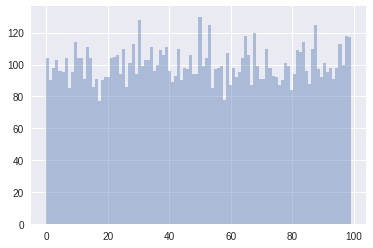

In [43]:
rng = PyLCG()
nums = rng.randint(size=10000) % 100
sns.distplot(nums, bins=100, kde=False);

In [53]:
%%timeit rng = PyLCG()
nums = rng.randint(size=10000)

6.3 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Cython version, extension types, and `cdef class`

In [88]:
%%cython -a

import numpy as np
cimport numpy as cnp
cimport cython

# Creates a new extension type: https://docs.python.org/3/extending/newtypes.html
cdef class CyLCG:
    
    # We declare the compile-time types of our *instance* variables here.
    # This is similar to C++ class declaration syntax.
    cdef long a, c, m, x
    
    # Special Cython-defined initializer.
    # Called before __init__ to initialize all C-level attributes.
    def __cinit__(self, long a=1664525, long c=1013904223, long m=2**32, long seed=0):
        self.a = a
        self.c = c
        if m <= 0:
            raise ValueError("m must be > 0, given {}".format(m))
        self.m = m
        self.x = seed
    
    # cdef / cpdef methods are supported
    @cython.cdivision(True)        
    cpdef long _advance(self):
        cdef long r = self.x
        self.x = (self.a * self.x + self.c) % self.m
        return r
    
    # Regular def method
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def randint(self, size=None):
        cdef long r
        if size is None:
            # Call to self._advance() here is efficient and at the C level.
            r = self._advance()
            return r
        cdef long[::1] a = np.empty((size,), dtype='i8')
        cdef int i
        cdef int n = int(size)
        for i in range(n):
            a[i] = self._advance()
        return np.asarray(a)

### Tests and timing

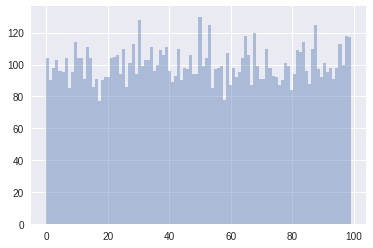

In [89]:
rng = CyLCG()
nums = rng.randint(size=10000) % 100
sns.distplot(nums, bins=100, kde=False);

In [90]:
%%timeit rng = CyLCG()
nums = rng.randint(size=10000)

165 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Pure-python memory usage
The sum of the number of bytes in:
* the `PyLCG()` object itself
* the instance `__dict__`
* and each key / value in the instance `__dict__`

In [59]:
import sys

In [79]:
pyrng = PyLCG()
(sys.getsizeof(pyrng) # the object itself
 + sys.getsizeof(pyrng.__dict__)  # the instance __dict__
 + sum(sys.getsizeof(k) + sys.getsizeof(v) for k, v in pyrng.__dict__.items())) # k/v memory use

512

We could improve this by using a `__slots__` attribute, but won't go down that road.

### Cython memory usage
The sum of the number of bytes in:
* The `CyLCG()` object itself
* each instance `long`

In [80]:
(sys.getsizeof(CyLCG()) # the object itself
 + 4 * 8) # The 4 8-byte longs (a, c, m, x)

88

## Public / private instance attributes

### Extension type instance attributes are not visibile to Python by default

In [81]:
cyrng = CyLCG(seed=42)

In [82]:
cyrng.a, cyrng.c, cyrng.m, cyrng.x
# => all give `AttributeError`

AttributeError: '_cython_magic_90ea9e967ab58a56035b2ac909248642.CyL' object has no attribute 'a'

### Extension type instances aren't open to new attributes

In [83]:
cyrng.z = 15

AttributeError: '_cython_magic_90ea9e967ab58a56035b2ac909248642.CyLCG' object has no attribute 'z'